**NOMS I COGNOMS: ANTONIO TIGRI VALDIVIA & ANDREU VALL HERNÀNDEZ** 

**GRUP DE LABORATORI: F**

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [1]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes

In [1]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [2]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Variables globals
YEARS = [2019, 2020, 2021]

lol


hello


Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [4]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [5]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [6]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', \
    'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data : pd.DataFrame, year, month, sampling_ratio=.05):
    """
    Funció que neteja les dades per un mes donat.
    """

    # Reduirem la taula a les columnes que ens interessa analitzar
    data = data[required_data].copy()

    # Primer per fer possible comparar les dates les passarem de string a un tipus date
    for col in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
        data[col] = pd.to_datetime(data[col])

    # Eliminarem els viatges amb dates que no coincideixin amb l'any i mes de la taula a la que pertanyen
    invalid_pickup_date = (data['tpep_pickup_datetime'].dt.year!=year) | (data['tpep_pickup_datetime'].dt.month!=month)
    invalid_dropoff_date = (data['tpep_dropoff_datetime'].dt.year!=year) | (data['tpep_dropoff_datetime'].dt.month!=month)

    # Eliminarem els viatges sense passatgers
    null_passengers = (data['passenger_count'] == 0) | data['passenger_count'].isna()

    '''
    Eliminarem els viatges en els que la distància sigui menor a 300 metres o major a 30km.
    Pel primer hem valorat que un viatge de tant poca distància és molt poc convencional i
    pel segon hem tingut en compte quants kilòmetres fan falta per recórrer el perímetre de
    manhattan. A més, hem analitzat els percentils per acabar de confirmar quin és el punt
    on els viatges poc convencionals són suficientment escassos com per poder eliminar-los
    sense perdre informació vital.
    '''
    invalid_distance = (data['trip_distance'] < 0.3) | (data['trip_distance'] > 30)

    # Eliminarem els viatges on el taxi ha viatjat al passat
    invalid_pickup_dropoff_times = data['tpep_pickup_datetime'] > data['tpep_dropoff_datetime']

    # També els que durin més de 10 hores (hi ha especialment un munt de viatges de 24h,
    # probablement significa que la data de pickup és incorrecta)
    invalid_duration = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']) > pd.Timedelta(10, 'h')

    '''
    Eliminarem els viatges amb pagaments de valor negatiu i els viatges amb pagaments de valors
    desorbitats. Com abans, per tenir una idea d'on traçar la línia hem utilitzat els percentils.
    També hem analitzat quan solen ser cars els viatges i coincideixen amb els viatges molt llargs,
    que de totes maneres han sigut eliminats, o viatges amb costs addicionals sense sentit (propines de Bill Gates?)
    '''
    invalid_fare = (data['total_amount'] < 0) | (data['total_amount'] > 500)

    # Juntarem totes les condicions en una sola variable per no haver d'iterar
    invalid_data = invalid_pickup_date | invalid_dropoff_date | null_passengers | invalid_distance | \
                   invalid_pickup_dropoff_times | invalid_duration | invalid_fare

    # Fem el drop de les dades invàlides
    data.drop(invalid_data[invalid_data==True].index, inplace=True)

    # Eliminarem per últim les dades amb nan en alguna de les columnes
    data.dropna(inplace=True)

    # Per últim retornarem el dataframe
    return data.sample(round(data.shape[0] * sampling_ratio))

In [7]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave=False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
df.to_parquet('data/taxi_data_reduced.parquet')

# Start Execution Here

In [1]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Variables globals
YEARS = [2019, 2020, 2021]

df = pd.read_parquet('data/taxi_data_reduced.parquet')

A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [2]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """

    # Columnes usades a partir de l'apartat 2
    data['year'] = data['tpep_pickup_datetime'].dt.year
    data['month'] = data['tpep_pickup_datetime'].dt.month
    data['year-month'] = data['year'].astype('str') + '-' + data['month'].astype('str').str.zfill(2)

    # Columnes usades a partir de l'apartat 3
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['pickup_day'] = data['tpep_pickup_datetime'].dt.dayofweek
    data['pickup_week'] = data['tpep_pickup_datetime'].dt.week
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month

    # Duració del viatge en minuts
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

    return data

Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [3]:
df = post_processing(df)
df.shape

C:\Users\ANDREU~1\AppData\Local\Temp/ipykernel_20576/3094541747.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['pickup_week'] = data['tpep_pickup_datetime'].dt.week


(6580830, 17)

## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [13]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """
    
    '''
    Agrupem el dataframe pel nombre de columnes desitjades i tot
    seguit obtenim el tamany per així extreure el nombre de dades
    que tenen cada valor de la columna escollida a "column"
    '''
    data = df.groupby(column).size()
    
    # Utilitzarem el gràfic de barres de seaborn ja que és el més fàcil de implementar de forma llegible
    sns.barplot(x=data.index, y=data)
    
    # Afegim els títols i etiquetes al gràfic
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

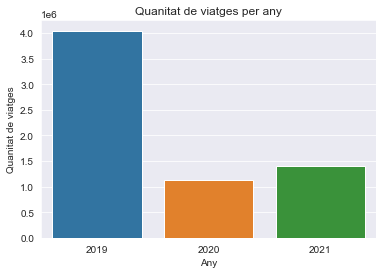

In [14]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')

**Pregunta: És el comportament que esperàveu? Per què?**

Sí, donat que el març de 2020 hi va haver un confinament global i en conseqüència el nombre de viatges en taxi a NY es va veure afectat, cosa que queda plasmada en la gràfica. En el 2021 veiem una lleugera recuperació, ja que s'han anat relaxant les mesures del covid.

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [15]:
def passengers_taxi_year(df, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """

    # Creem la figura on posarem els 3 gràfics (un per cada any)
    fig, axs = plt.subplots(ncols=3, figsize=(21, 8))

    ylim = 0

    # Iterarem pels 3 anys per a mostrar cada gràfic a la figura
    for i, year in enumerate(YEARS):

        '''
        Agruper per els mesos de l'any de la iteració actual i fem
        la suma dels valors de la columna "passenger_count", obtenint
        així el nombre de passatgers totals per mes
        '''
        data = df[df['year']==year].groupby('month')['passenger_count'].sum()

        # Canviem el format de dades a percentatge en funció del paràmetre "norm"
        if norm:
            data = 100 * data / data.sum()
        
        # Utilitzarem el gràfic de barres de seaborn ja que és el més fàcil de implementar de forma llegible
        sns.barplot(x=data.index, y=data, ax=axs[i], palette='crest')
        ylim = max(ylim, data.max())
        
        # Afegim els títols i etiquetes al gràfic
        axs[i].title.set_text(title + f' ({year})')
        axs[i].set(xlabel=xlabel)
        axs[i].set(ylabel=ylabel)
    
    for ax in axs:
        ax.set(ylim=(0, ylim))

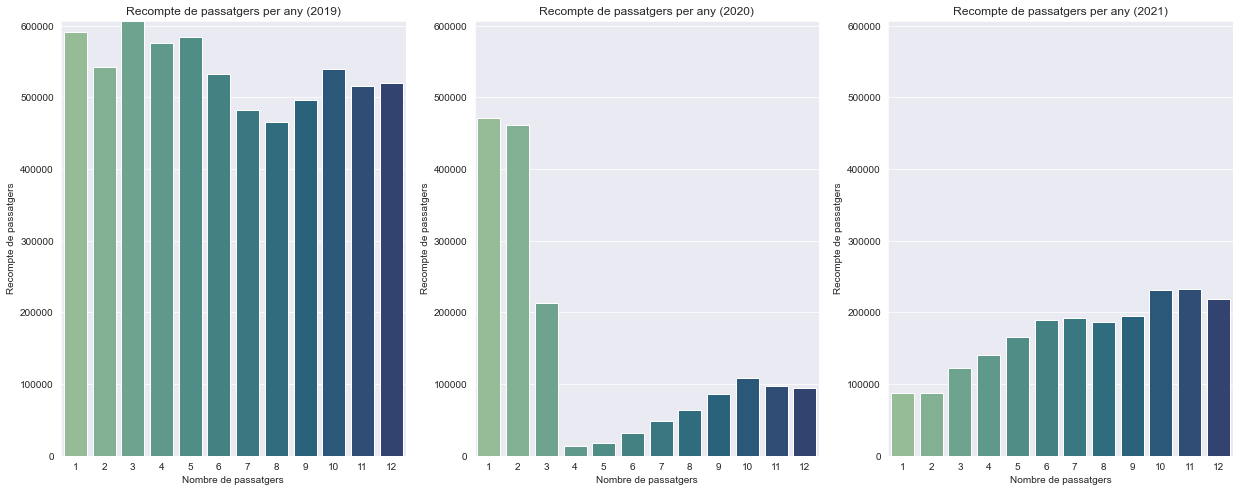

In [16]:
passengers_taxi_year(df, 'Nombre de passatgers', 'Recompte de passatgers', 'Recompte de passatgers per any')

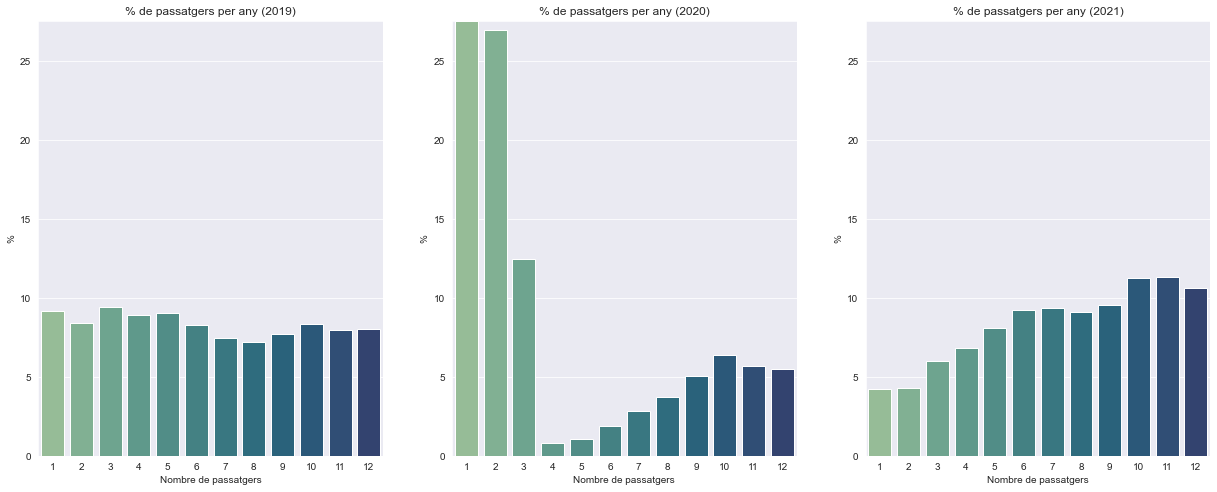

In [17]:
passengers_taxi_year(df, 'Nombre de passatgers', '%', '% de passatgers per any', norm=True)

A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [33]:
def passengers_taxi(df, xlabel, ylabel, norm=False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """

    '''
    Per tenir tot en un sol gràfic necessitarem agrupar per
    parelles unificades (és a dir, que el mes contingui de
    forma directa l'any al que pertany) i procedirem com abans
    '''
    data = df.groupby('year-month')['passenger_count'].sum()

    # Canviem el format de dades a percentatge en funció del paràmetre "norm"
    if norm:
        data = 100 * data / data.sum()

    # Creem la figura on anirà el gràfic, establint el tamany i l'angle de els elements de l'eix x
    plt.figure(figsize=(21, 8))
    plt.xticks(rotation=45)

    # Creem el gràfic de barres com en cel·les anteriors
    sns.barplot(x=data.index, y=data, palette='crest')

    # Afegim els títols i etiquetes
    title = 'Percentage' if norm else 'Count'
    plt.title(f'Passenger {title} by Month')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

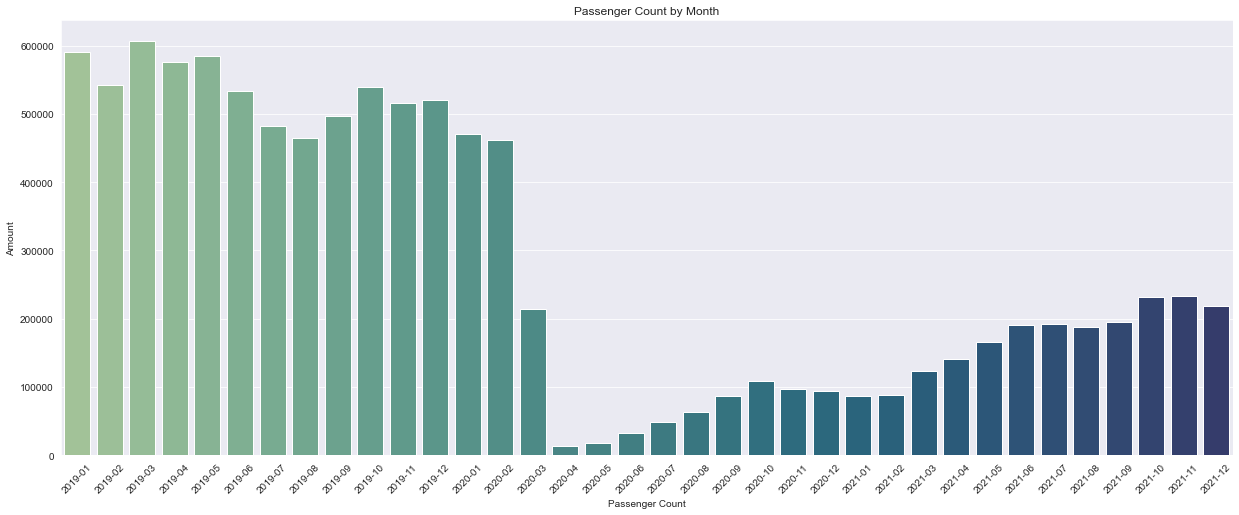

In [34]:
passengers_taxi(df, 'Passenger Count', 'Amount')

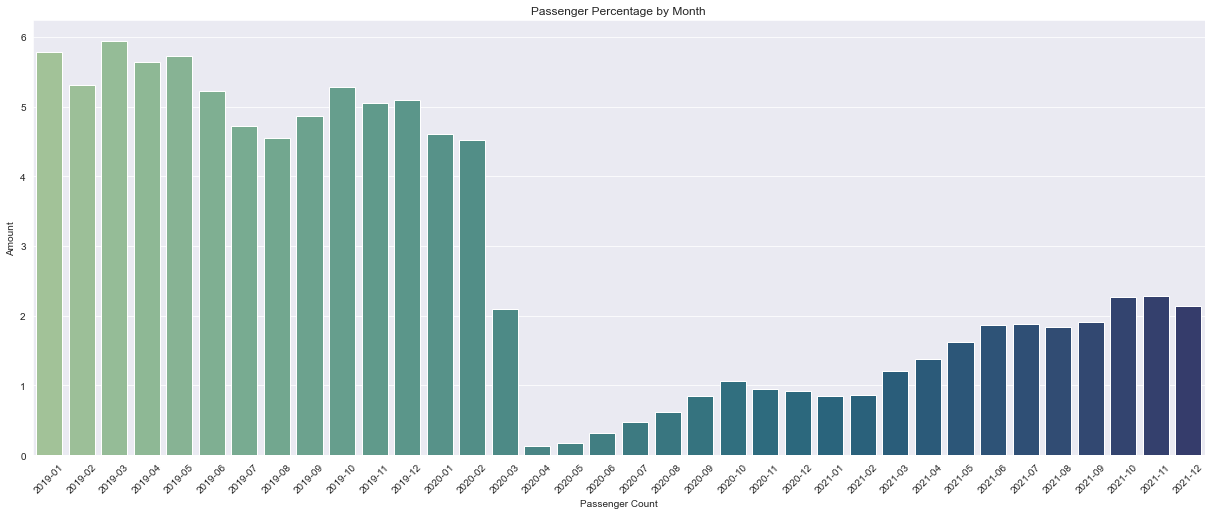

In [20]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm=True)

**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

El març del 2020 es van reduir els viatges a la meitat respecte els mesos anterior, i a partir de l'abril es redueix enormement. Això és degut a que el confinament va començar aproximadament a la meitat del març, i per tant va tenir un impacte molt important (es redueix a menys d'un 5% dels viatges que hi havia fins el moment). A partir de llavors el nombre de viatges va tornar a créixer lentament però fins el final del 2021 la quantitat de viatges no ha arribat a la meitat de viatges que hi havia fins abans de la pandèmia. 

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [31]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    
    '''
    Com no creiem que utilitzar la dropoff_hour ens doni molta
    informació, ja que els viatges no haurien de tenir una durada
    suficientment llarga com per poder extreure conclusions de la
    columna, utilitzarem només la data de recollida de la persona
    del viatge. Per obtenir-ne el conteig usarem el paràmetre size
    '''
    data = df.groupby(columns[0]).size()

    # Creem la figura on hi haurà el gràfic i establim el tamany
    plt.figure(figsize=(21, 6))

    # Posem el títol i les etiquetes
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Creem el gràfic amb els paràmetres desitjats
    plt.plot(data.index, data, marker='o', linestyle='dashed')

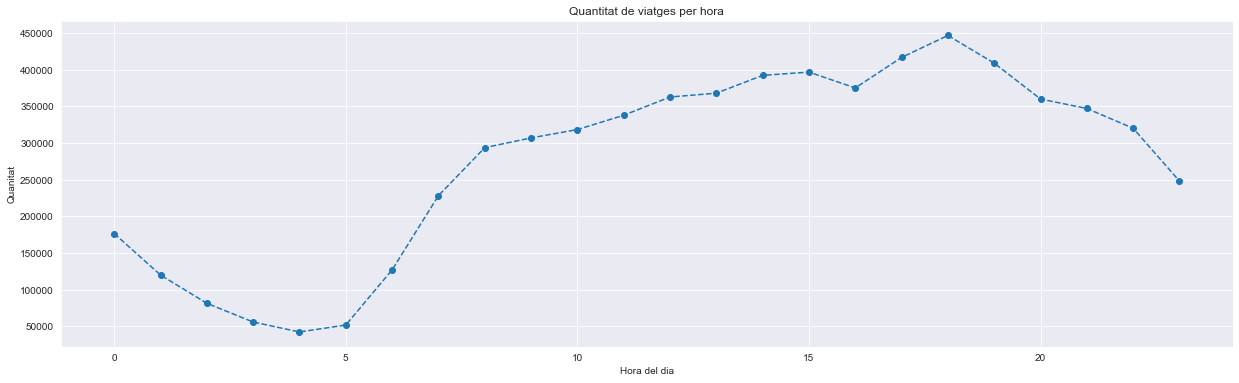

In [27]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Quantitat de viatges per hora', xlabel = 'Hora del dia', ylabel = 'Quanitat')

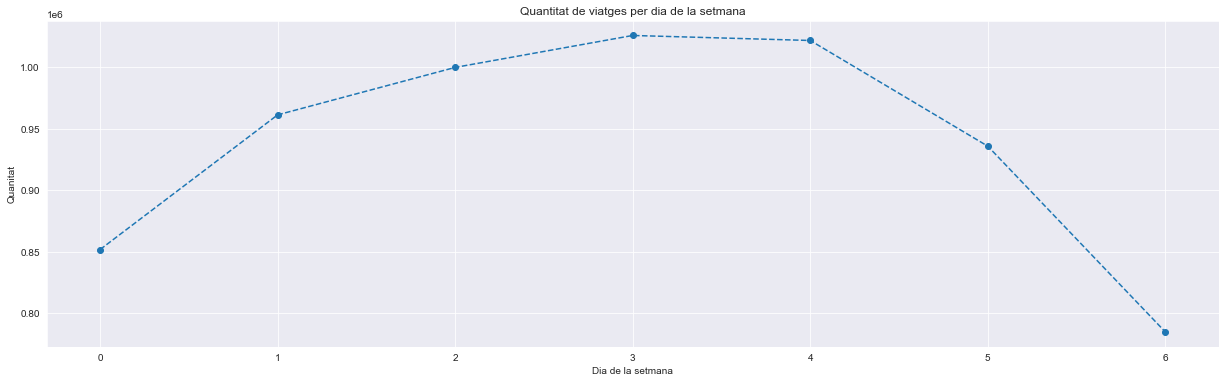

In [32]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Quantitat de viatges per dia de la setmana', xlabel = 'Dia de la setmana', ylabel = 'Quanitat')

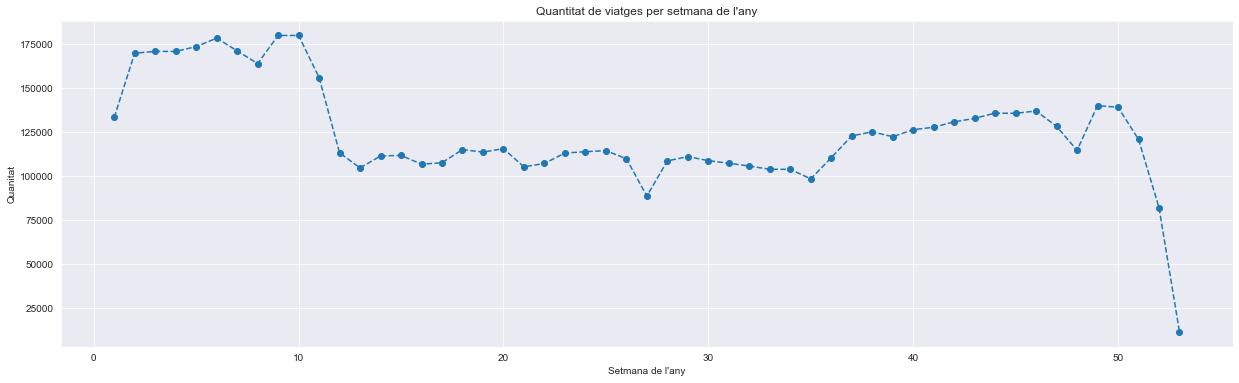

In [25]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Quantitat de viatges per setmana de l\'any', xlabel = 'Setmana de l\'any', ylabel = 'Quanitat')

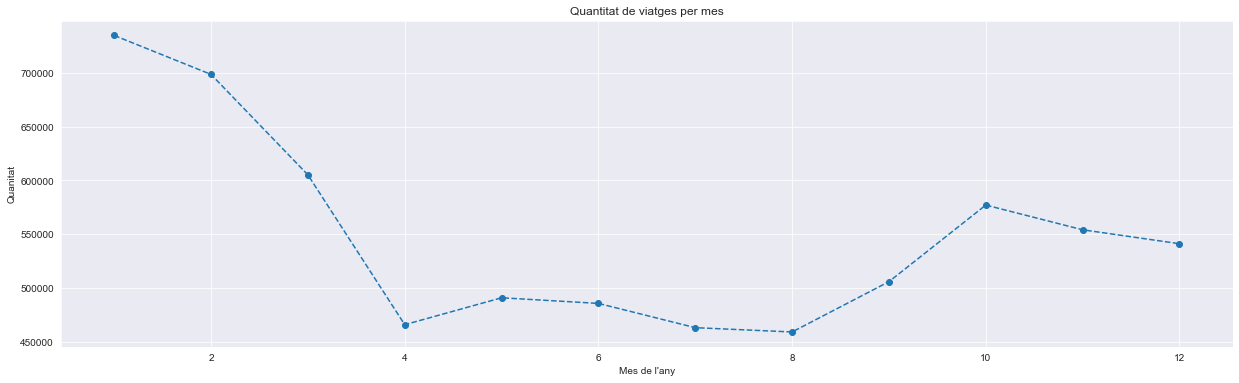

In [26]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Quantitat de viatges per mes', xlabel = 'Mes de l\'any', ylabel = 'Quanitat')

**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

Hora -> Normalment la gent agafa taxis durant el dia, amb un pic a la tarda (les hores normals de finalització de la jornada laboral)
Dia -> 
Setmana -> Les 2 últimes setmanes hi ha signficativament menys viatges, perquè probablement és nadal i a més la majoria dels anys no tenen la última setmana. També es veu que les primeres 10 setmanes tenen més viatges, ja que el 10 març de l'any 2020 hi va haver una caiguda important en el nº viatges
Mesos -> Similar a les setmanes, es veu la caiguda del covid de mes 2 al 4. L'increment en els últims mesos pot ser degut a la recuperació de viatges del 2021 post pandèmia.

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [8]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """
    
    # AQUÍ EL TEU CODI

    fig, axs = plt.subplots(ncols=3, figsize=(21, 8))

    # Perquè el gràfic es vegi correctament farem 20 bins
    nbins = 10
    ylim = 0

    for i, year in enumerate(YEARS):

        bin_width = xlim[1] / nbins
        data = (df.loc[(df['year']==year) & (df[column] < xlim[1]), column] // bin_width * bin_width).value_counts()

        data = 100 * data / data.sum()

        sns.barplot(x=data.index, y=data, ax=axs[i])

        # Afegim els títols i etiquetes al gràfic
        axs[i].title.set_text(title + f' ({year})')
        axs[i].set(xlabel=xlabel)
        axs[i].set(ylabel=ylabel)

        ylim = max(ylim, data.max())

    for ax in axs:
        ax.set(ylim=(0, ylim))

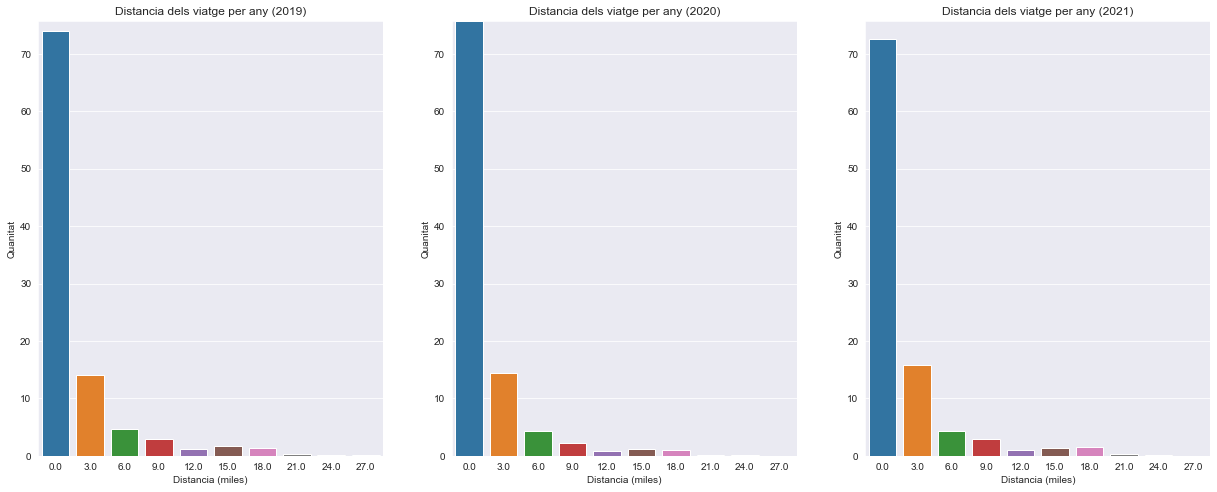

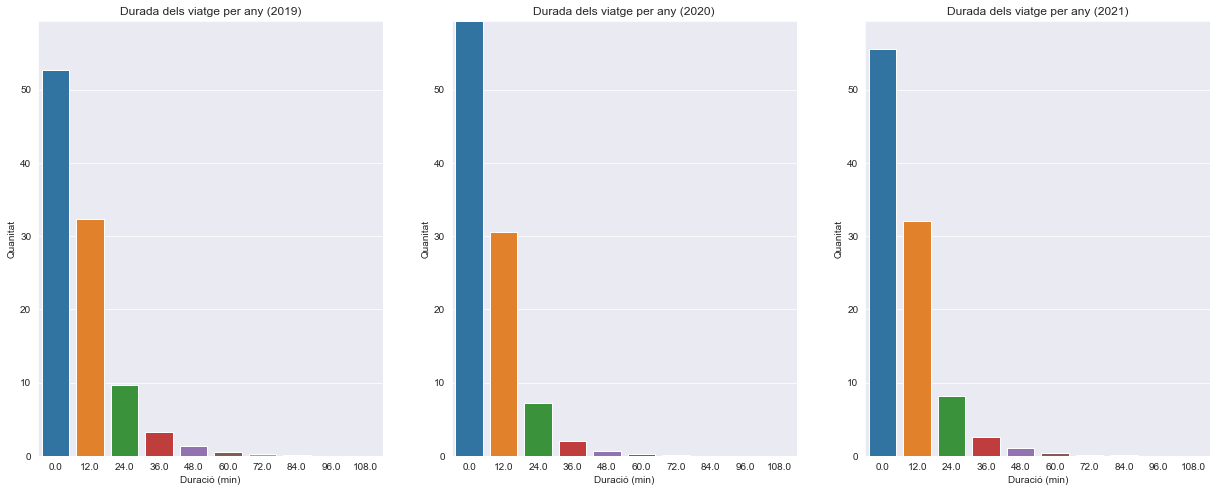

In [9]:
# Vam decidir tallar els viatges més grans que 30 milles, per tant tallarem el gràfic a 30 milles
# La columna trip_distance era originalment en milles i preferim no canviar-la
visualize_histograms(df, 'trip_distance', title = 'Distancia dels viatge per any',
                     xlabel = 'Distancia (miles)', ylabel = 'Quanitat', xlim = (-5, 30))

# I tallarem les hores 2 hores, ja que tallant en 10 hores el gràfic pràcticament no mostra res útil
# (gairebé tots els viatges tenen menys de 1 hora de durada)
visualize_histograms(df, 'trip_duration', title = 'Durada dels viatge per any', 
                     xlabel = 'Duració (min)', ylabel = 'Quanitat', xlim = (-1, 120))

**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER
P

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

<AxesSubplot:>

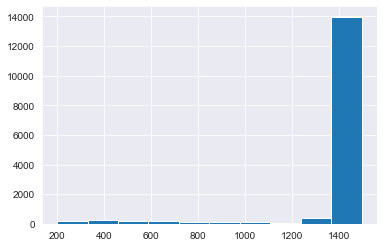

In [35]:
a = df['trip_duration']
a[(a<1500) & (a>200)].hist()

In [29]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Funció que mostra un scatter plot donades dues dades
    """
    # AQUÍ EL TEU CODI
    fig, axs = plt.subplots(ncols=3, figsize=(21, 9))

    for i, year in enumerate(YEARS):
        df_year = df[df['year']==year]
        sns.scatterplot(x=df_year[x_value], y=df_year[y_value], ax=axs[i])
        axs[i].set(ylim=(-100, 1600))

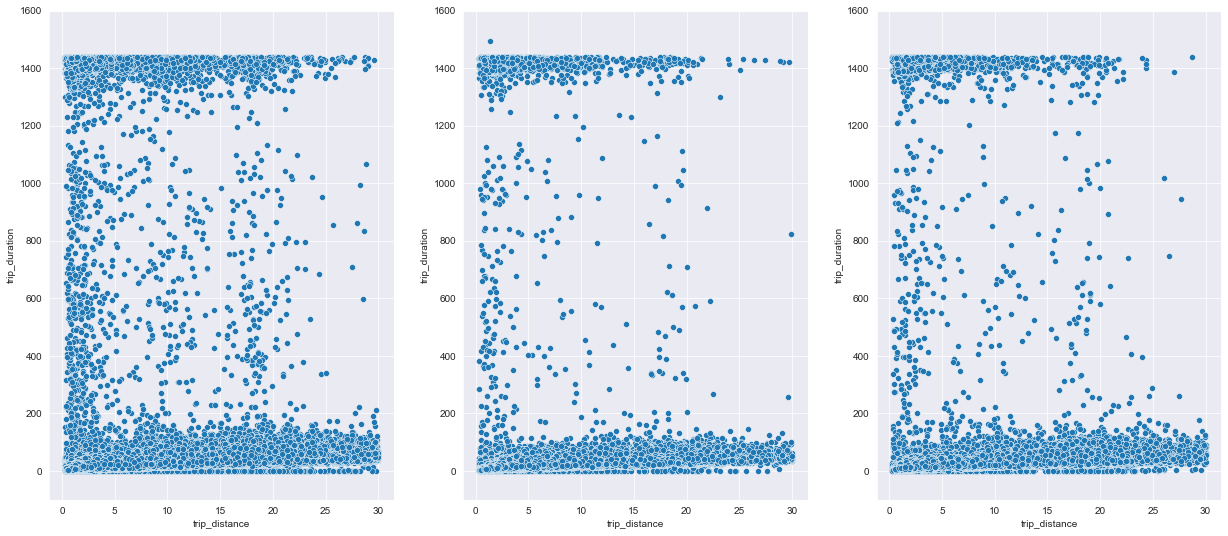

In [30]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (miles)', 'Temps (min)')

In [ ]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (miles)', 'Temps (min)', True)

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [ ]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració dels trajectes en un temps a determinar
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Setmana de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per setmanes')

In [ ]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per mesos')

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Setmana de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per setmanes')

In [ ]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per mesos')

**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER

Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [ ]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """
    
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeteix els gràfics anteriors visualitzant la distancia.

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Dies de l\'any', 'Hores del dia')

In [ ]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

In [ ]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar la velocitat un mapa de calor
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER

## 05. Visualitzem les localitzacions dels viatges

In [ ]:
df.head()

Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [ ]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [ ]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [ ]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [ ]:
# AQUÍ EL TEU CODI

merge = ...

In [ ]:
merge.shape

## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [ ]:
# Recollida
# AQUÍ EL TEU CODI
top_pu = ...

# Destí
# AQUÍ EL TEU CODI
top_do = ...

In [ ]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    """
    Funció que mostra els llocs més usuals per any
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
show_top_n(top_pu, 'PULocationID', df_loc)

In [ ]:
show_top_n(top_do, 'DOLocationID', df_loc)

**Visualitzem amb un mapa de calor quines són les zones més recurrents**

In [ ]:
for year in YEARS:
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'trip_distance']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [ ]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

In [ ]:
def scatter_locations(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
scatter_locations(merge, hospitals)

In [ ]:
def scatter_locations_per_year(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
scatter_locations_per_year(merge, hospitals)

**Pregunta: Veus algun comportament?**
>ANSWER

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [ ]:
from scipy.spatial import distance_matrix

In [ ]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values


# AQUÍ EL TEU CODI    
dist = ...

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [ ]:
# AQUÍ EL TEU CODI
hospitals_locations = ...
hospitals['LocationID'] = hospitals_locations

In [ ]:
hospitals.head()

Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [ ]:
def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """
    # AQUÍ EL TEU CODI
    raise NotImplementedError

In [ ]:
trips_hospitals(df, hospitals_locations)

## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

## 09. Informe

A partir de l'exploració de les dades que heu fet al llarg d'aquest notebook, feu un petit informe resumint i justificant tots els canvis que han sorgit a causa de la covid.